In [629]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib as mpl

import os
import pandas as pd

import matplotlib.pyplot as plt

In [673]:
# https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

file = 'INVEB.SESEK_Candlestick_1_M_BID_01.08.2019-12.07.2022.csv'
#file = 'HMB.SESEK_Candlestick_1_M_BID_01.08.2019-13.07.2022.csv'
file = 'XAUUSD_Candlestick_1_M_BID_01.08.2019-09.07.2022.csv'
#file = 'DEU.IDXEUR_Candlestick_1_M_BID_01.08.2019-16.07.2022.csv'

df = pd.read_csv('data\\' + file)
df = df.rename(columns = {'Local time':'datetime'})
df.columns = df.columns.str.lower()
df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc = True).dt.tz_convert(tz='Europe/Stockholm')

df = df.sort_values(by='datetime')

# STRIP
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['price'] = df[['close', 'open', 'low', 'high']].mean(axis=1)
df = df.drop(columns=['high', 'low', 'open', 'close', 'volume', 'datetime'])
df.head()

,date,time,price
0,2019-08-01,00:00:00,1411.51075
1,2019-08-01,00:01:00,1412.46975
2,2019-08-01,00:02:00,1413.95725
3,2019-08-01,00:03:00,1415.08050
4,2019-08-01,00:04:00,1415.88475


In [674]:
df = df.set_index(['date','time'])[['price']].unstack().ffill(axis=1).bfill(axis=1).stack().reset_index()
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

df['datetime_diff'] = df['datetime'].diff()
df['hour_gap'] = df['datetime_diff'] / np.timedelta64(1, 'h')
df['new_day'] = 0
df.loc[df['hour_gap'] > 10,'new_day'] = 1
df['return'] = df['price'].pct_change().add(1)
df['return_cum'] = df['return'].cumprod()
df.head()

,date,time,price,datetime,year,month,day,hour,datetime_diff,hour_gap,new_day,return,return_cum
0,2019-08-01,00:00:00,1411.51075,2019-08-01 00:00:00,2019,8,1,0,NaT,NaN,0,NaN,NaN
1,2019-08-01,00:01:00,1412.46975,2019-08-01 00:01:00,2019,8,1,0,0 days 00:01:00,0.016667,0,1.000679,1.000679
2,2019-08-01,00:02:00,1413.95725,2019-08-01 00:02:00,2019,8,1,0,0 days 00:01:00,0.016667,0,1.001053,1.001733
3,2019-08-01,00:03:00,1415.08050,2019-08-01 00:03:00,2019,8,1,0,0 days 00:01:00,0.016667,0,1.000794,1.002529
4,2019-08-01,00:04:00,1415.88475,2019-08-01 00:04:00,2019,8,1,0,0 days 00:01:00,0.016667,0,1.000568,1.003099


<AxesSubplot:xlabel='datetime'>

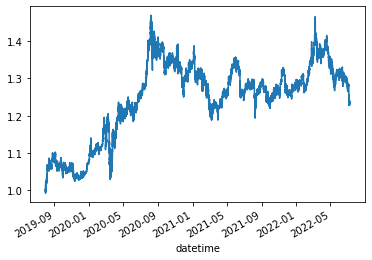

In [675]:
df.set_index(['datetime'])['return_cum'].plot()

In [676]:
for minutes in [10, 30, 60, 120, 240, 480]:
    #df['return_'+str(minutes)+'min'] = df['price'].pct_change(minutes).add(1)
    #df['return_'+str(minutes)+'min_shifted'] = df['return_'+str(minutes)+'min']
    
    #df['feat_return_'+str(minutes)+'min_avg'] = df['return'].rolling(minutes).mean()
    #df['feat_return_'+str(minutes)+'min_median'] = df['return'].rolling(minutes).median()
    #df['feat_return_'+str(minutes)+'min_std'] = df['return'].rolling(minutes).std()
    df['feat_price_'+str(minutes)+'min_max'] = df['price'].rolling(minutes).max()
    df['feat_price_'+str(minutes)+'min_max_shifted'] = df['feat_price_'+str(minutes)+'min_max'].shift(minutes)
    df['feat_price_'+str(minutes)+'min_min'] = df['price'].rolling(minutes).min()
    df['feat_price_'+str(minutes)+'min_min_shifted'] = df['feat_price_'+str(minutes)+'min_min'].shift(minutes)
    
    #df['feat_price_'+str(minutes)+'min_mean'] = df['price'].rolling(minutes).mean()
    #df['feat_price_'+str(minutes)+'min_std'] = df['price'].rolling(minutes).std()
    #df['feat_price_'+str(minutes)+'min_max'] = df['price'].rolling(minutes).max()
    #df['feat_price_'+str(minutes)+'min_max_shifted'] = df['feat_price_'+str(minutes)+'min_max'].shift(minutes)
    #df['feat_price_'+str(minutes)+'min_min'] = df['price'].rolling(minutes).min()
    #df['feat_price_'+str(minutes)+'min_min_shifted'] = df['feat_price_'+str(minutes)+'min_min'].shift(minutes)

In [677]:
features = [column for column in df.columns if 'feat_' in column]
df[features] = df[features].div(df['price'], axis=0)

## ML

In [678]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics 
from sklearn import tree

In [698]:
hold_time_h = 2
pct_change = 0.005

df['price_pct'] = df['price'].shift(-hold_time_h*60).div(df['price'])
df['price_pct_up'] = 0
df.loc[df['price_pct']>1 + pct_change, 'price_pct_up'] = 1

df['price_pct'] = df['price'].shift(-hold_time_h*60).div(df['price'])
df['price_pct_down'] = 0
df.loc[df['price_pct']<1 - pct_change, 'price_pct_down'] = 1

print(df['price_pct_up'].mean())
print(df['price_pct_down'].mean())

0.032323724895246354
0.03509156913740789


In [699]:
from datetime import time

corona_low = '2020-03-01'
corona_high = '2020-05-01'
from_date = '2022-01-01'
to_date = '2022-02-01'
df_train = df[#((df['date']<corona_low) | (df['date']>corona_high))  & 
              ((df['date']<to_date))
            & ((df['time']>time(10, 0)) & (df['time']<time(16, 0)))
             ].copy()
df_test = df[((df['date']>=to_date))].copy()

In [700]:
#MODEL
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_up']

scale_pos_weight = Y[Y == 0].count()/Y[Y==1].count()
print('scale pos: ',scale_pos_weight)

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 3, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

scale pos:  14.305475880052152


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [701]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_up']

y_pred = model.predict_proba(X)
#accuracy = accuracy_score(Y, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_up'] = y_pred[:,1]
print(df['pred_price_pct_up'].mean())

0.06457281112670898


<AxesSubplot:>

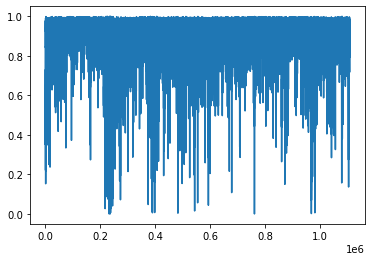

In [692]:
df['pred_price_pct_up'].plot()

### SELL

In [702]:
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_down']

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 3, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [708]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_down']

y_pred = model.predict_proba(X)
#accuracy = accuracy_score(Y, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_down'] = y_pred[:,1]
print(df['pred_price_pct_down'].mean())

0.07356390357017517


# MAKE MODELS

In [709]:
df['action'] = np.nan
df['price_buy'] = np.nan
df['buy_hold'] = np.nan

buy_strategy = 'ml'
sell_strategy = 'ml'

signal = 'avg'

if buy_strategy == 'ml':
    #df['action'] = df['pred_price_pct_up'] - df['pred_price_pct_down']
    df.loc[df['pred_price_pct_up']>0.8, 'action'] = 1 

if sell_strategy == 'ml':
    df.loc[df['pred_price_pct_down']>0.8, 'action'] = -1

#df['action'] = df['action'].ffill(limit=4*60)
    
if sell_strategy == 'blank':
    pass
    #df.loc[df['pred_price_pct_down']==1, 'action'] = -1
        

#df['action'] = df['action'].ffill(limit=1*60)
        
# BUY
# Momentum
if buy_strategy == 'momentum':
    df.loc[#(df['hour']>=9) & (df['hour']<17) &
        #(df['feat_price_240min_max'].div(df['feat_price_240min_min']) > 1.005) &
           #(df['feat_price_60min_min']>df['feat_price_120min_min']) &
           (df['feat_price_60min_max']==df['price']) 
           #& (df[f'feat_return_120min_std']>df[f'feat_return_480min_std'])
           #& (df[f'feat_return_60min_std']>df[f'feat_return_120min_std'])
           & (df[f'feat_return_30min_{signal}']>df[f'feat_return_60min_{signal}'])
           & (df[f'feat_return_10min_{signal}']>df[f'feat_return_15min_{signal}'])
           & (df[f'feat_return_15min_{signal}']>df[f'feat_return_30min_{signal}'])
           #& (df[f'feat_return_30min_{signal}']>df[f'feat_return_60min_{signal}'])
           #& (df[f'feat_return_60min_{signal}']>df[f'feat_return_120min_{signal}'])
           #& (df['return_cum'] >= df['return_240min_max'])
           #& (df['return_30min_median']>1)
           , 'action'] = 1
    
df.loc[df['action']==1, 'price_buy'] = df['price']
df['price_buy'] = df['price_buy'].ffill()

df['action_number'] = df['action'].fillna(0).cumsum()
df['price_max'] = df.groupby('action_number')['price'].cummax()
    
if sell_strategy == 'trailing_stop':
    df.loc[df['price'] < df['price_max']*0.99, 'action'] = -1
    
    df['action'] = df['action'].ffill(limit=1*60)
    df['action'] = df['action'].fillna(-1)
    
    
if sell_strategy == 'profit':
    df.loc[(df['price'] > df['price_buy']*1.005), 'action'] = -1
    
    df['action'] = df['action'].ffill(limit=4*60)
    #df['action'] = df['action'].fillna(-1)
    
signal = 'avg'
#SELL

if sell_strategy == 'time':
    df['action'] = df.groupby('year')['action'].ffill(limit=60)


if sell_strategy == 'momentum':
    df.loc[#(df['feat_price_60min_min']==df['price']) &
           (df[f'feat_return_5min_{signal}']<df[f'feat_return_10min_{signal}'])
           & (df[f'feat_return_10min_{signal}']<df[f'feat_return_15min_{signal}'])
           & (df[f'feat_return_15min_{signal}']<df[f'feat_return_30min_{signal}'])
           #& (df[f'return_10min_{signal}']<df[f'return_15min_{signal}'])
           #& (df[f'return_20min_{signal}']<df[f'return_30min_{signal}'])
           & (df[f'feat_return_30min_{signal}']<df[f'feat_return_60min_{signal}'])
           #& (df[f'return_60min_{signal}']<df[f'return_120min_{signal}'])
           #& (df[f'return_120min_{signal}']<df[f'return_180min_{signal}'])
           #& (df['return_30min_median']>1)
           , 'action'] = -1


    
#df = df.set_index(['date','time'])
#df['price_max'] = df['fika_price'].unstack().cummax(axis=1).stack()
#df = df.reset_index()

#df['fika_sell'] = np.nan
#df.loc[(df['fika_price'] < df['fika_max']*0.995),'fika_sell'] = 1

# HOLD STOCK UNTIL SELL SIGNAL
#df['action'] = df['action'].ffill(limit=1*60)
#df['action'] = df['action'].replace(0, np.nan).ffill().shift(1)


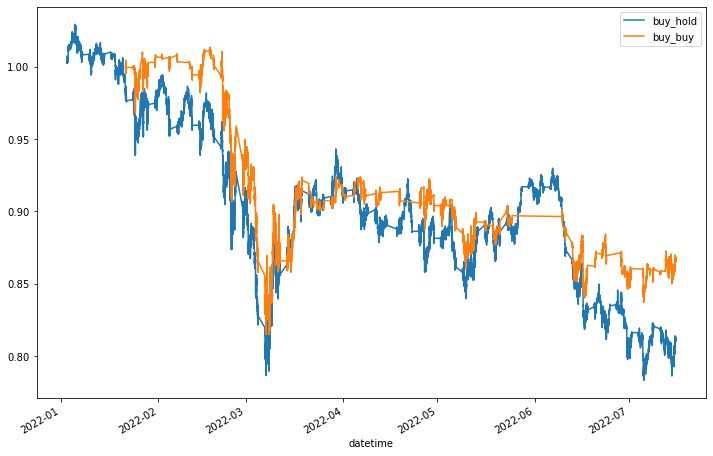

In [625]:
#df['action'] = df['action'].replace(-1,np.nan)
f, ax = plt.subplots(figsize= (12, 8))
df_cell = df[df['date']>'2022-01-01']
df_cell.set_index('datetime')['return'].cumprod().plot(ax=ax)
#dates = df[(df['date']>'2022-06-01') & (df['action']==1)]['datetime']

#df_cell.loc[dates].plot(ax=ax, ls='', marker='o')
df_cell.loc[df['action']==1].set_index('datetime')['return'].sub(1).cumsum().add(1).plot(ax=ax)
#df_cell.loc[df['action']==1].set_index('datetime')['return'].cumprod().plot(ax=ax)
ax.legend(['buy_hold', 'buy_buy', 'buy_invest'])
#df[df['datetime'].isin()]

In [458]:
df['action_number'] = df['action'].replace(-1,0).fillna(0).diff().replace(-1, 0).cumsum()
df_actions = df[(df['action']==1) & (df['year']==2022)].groupby(['action_number'])['return'].agg(('prod', 'count'))
df_actions.sort_values(by='prod')
df_actions['count'].shape[0]/df['date'].nunique()

0.8704188481675392

0.0316462155412367


<AxesSubplot:ylabel='Frequency'>

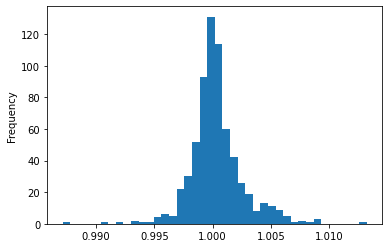

In [459]:
print((df_actions['prod'].mean()-1)*100)
df_actions['prod'].plot(kind='hist', bins=40)

6


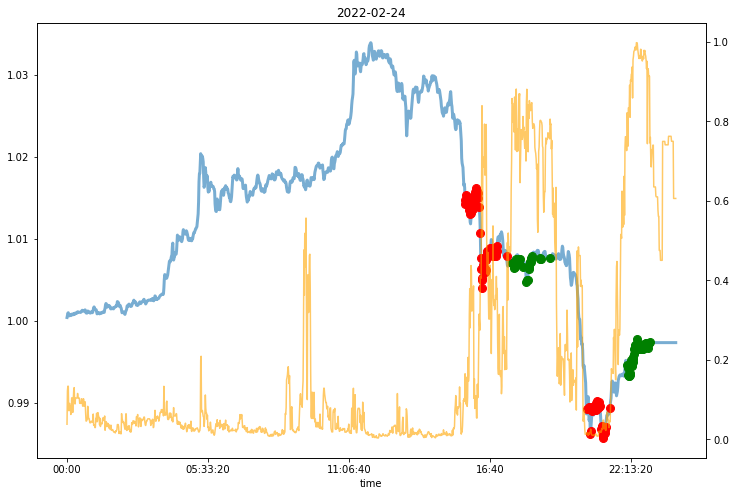

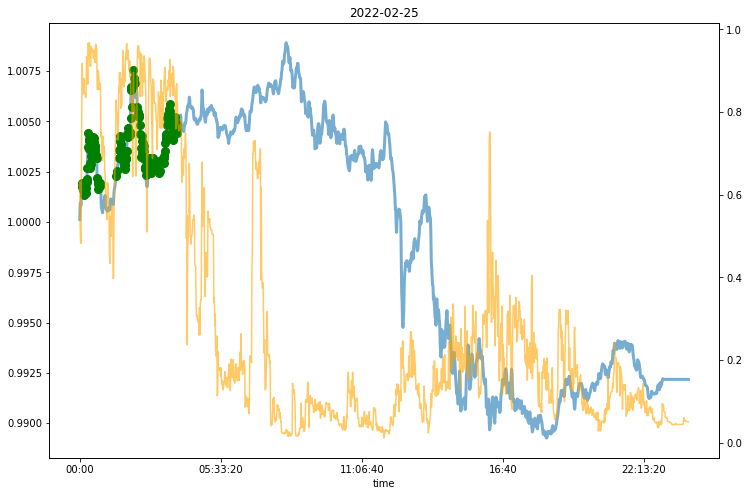

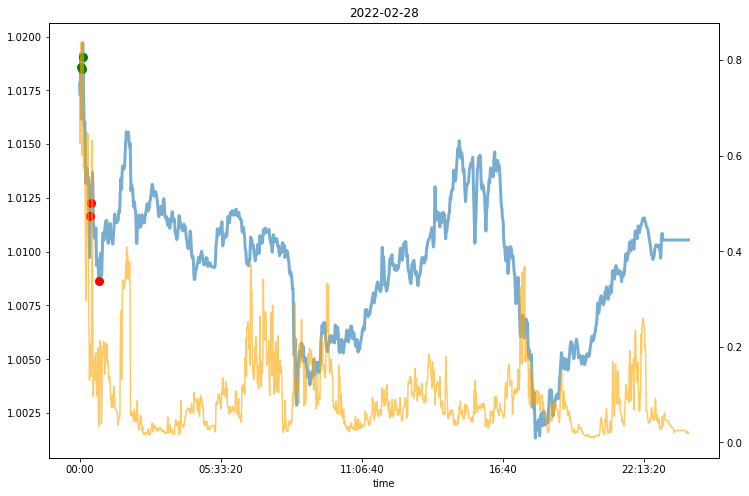

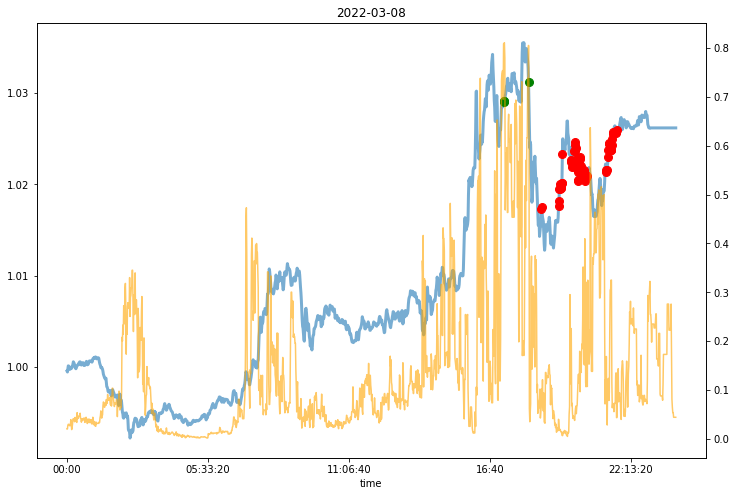

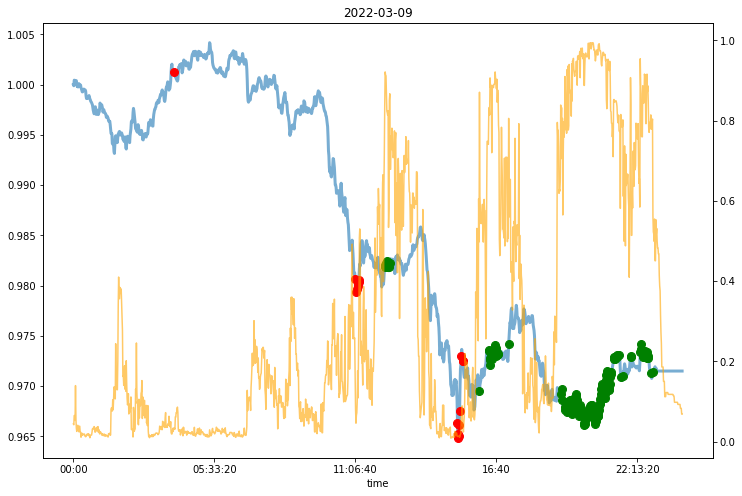

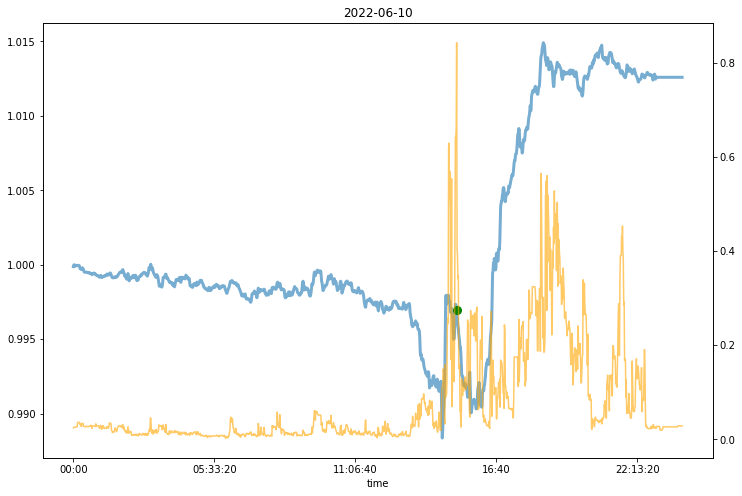

In [710]:
dates = df[(df['action']==1) & (df['date']>='2022-02-01') & (df['date']<'2022-07-01')]['date'].sort_values().unique()
print(len(dates))
#random_date = np.random.choice(dates, 10, replace = False)
#random_date = df[df['new_day']==0].groupby('date')['return'].prod().sort_values().head(20).index
#random_date = df.groupby('date')[['price']].agg(['min', 'max']).pct_change(axis =1).sort_values(by=('price', 'max')).tail(20).index
#random_date = df[df['action']==1].groupby('date')['return'].prod().sort_values(ascending=False).index


for day in dates[0:20]:
    f, ax = plt.subplots(figsize= (12, 8))
    
    min_hour = 0
    max_hour = 25
    
    df_filt = df[(df['date']==day) & (df['hour']>=min_hour) & (df['hour']<max_hour)]
    df_cum = df_filt.set_index('time')['return'].cumprod()
    df_cum.plot(title=f'{day}'[:10],ax=ax, lw=3, alpha = 0.6)
    #df[(df['date']==day)].set_index('time')['return_10min_avg'].plot(ax=ax, lw=2)
    #df[(df['date']==day)].set_index('time')['return_20min_avg'].plot(ax=ax, lw=2)
    #df[(df['date']==day)].set_index('time')['return_30min_avg'].plot(ax=ax, lw=2)
    
    
    df_cum.loc[df[(df['date']==day) & (df['hour']>=min_hour) & 
                  (df['hour']<max_hour) & (df['action']==1)]['time'].values].plot(ax=ax, ls='', marker='o', color='g', ms=8)
    df_cum.loc[df[(df['date']==day) & (df['hour']>=min_hour) & 
                  (df['hour']<max_hour) & (df['action']==-1)]['time'].values].plot(ax=ax, ls='', marker='o', color='r', ms=8)
    
    ax2 = ax.twinx()
    df_filt.set_index('time')['pred_price_pct_up'].plot(ax=ax2, alpha = 0.6, color = 'orange')
    #df[(df['date']==day) & (df['hour']>=min_hour) & (df['hour']<max_hour) & (df['action']==1)].set_index('time')['action_number'].plot(ax=ax2)
    #df[(df['date']==day) & (df['hour']>=min_hour) & (df['hour']<max_hour) & (df['action']==1)].set_index('time')['return'].cumprod().plot(ax=ax2)
    #df_cum.loc[df[df['return_10min']==1.002]['datetime'].values].plot(ax=ax, ls='', marker='o')
    #ax.axvline('09:00', color='grey', ls='--')
    #ax.axvline('10:00', color='grey', ls='--')
    #ax2.axvline('11:00', color='grey', ls='--')
    #ax2.axhline(1, color='grey', ls='--')
    

### MODEL

In [575]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics 
from sklearn import tree

In [613]:
hold_time_h = 4

df['price_pct'] = df['price'].shift(-hold_time_h*60).rolling(hold_time_h*60).max().div(df['price'])
df['price_pct_up'] = 0
df.loc[df['price_pct']>1.005, 'price_pct_up'] = 1

df['price_pct_up'].mean()

0.2216218601094182

In [614]:
hold_time_h = 4

df['price_pct'] = df['price'].shift(-hold_time_h*60).div(df['price'])
df['price_pct_down'] = 0
df.loc[df['price_pct']<1, 'price_pct_down'] = 1

df['price_pct_down'].mean()

0.47151204972841537

In [615]:
test_year = 2022
df_train = df[df['year']!=test_year].copy()
df_test = df[df['year']==test_year].copy()


In [616]:
#MODEL
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_up']

scale_pos_weight = Y[Y == 0].count()/Y[Y==1].count()
print('scale pos: ',scale_pos_weight)

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 4, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

scale pos:  3.960582874061391


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [617]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_up']

y_pred = model.predict(X)
accuracy = accuracy_score(Y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_up'] = y_pred
print(df['pred_price_pct_up'].mean())

Accuracy: 80.87%
0.0822234641253407


### SELL

In [618]:
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_down']

scale_pos_weight = Y[Y == 0].count()/Y[Y==1].count()
print('scale pos: ', scale_pos_weight)

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 4, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

scale pos:  1.1477220953788099


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [620]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_down']

y_pred = model.predict(X)
accuracy = accuracy_score(Y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_down'] = y_pred
print(df['pred_price_pct_down'].mean())

Accuracy: 59.09%
0.2304037492401514


### SLUT

In [149]:
#BALANCE DATASET

from sklearn.utils import resample
X_oversampled, y_oversampled = resample(X[Y == 1],
                                        Y[Y == 1],
                                        replace=True,
                                        n_samples=X[Y == 0].shape[0],
                                        random_state=123)

X_balanced = np.vstack((X[Y == 0], X_oversampled))
y_balanced = np.hstack((Y[Y == 0], y_oversampled))

In [150]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_leaf_nodes=8, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=test_size)
# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.612660219303393


In [154]:
df.tail()

,date,time,price,datetime,year,month,day,hour,datetime_diff,hour_gap,...,feat_price_240min_max,feat_price_240min_max_shifted,feat_price_240min_min,feat_price_240min_min_shifted,pred_price_pct,pred_price_pct_up,action,price_buy,buy_hold,action_number
1019935,2022-07-15,22:10:00,12862.6165,2022-07-15 22:10:00,2022,7,15,22,0 days 00:01:00,0.016667,...,1.0,1.0,1.0,0.99,NaN,0,-1.0,12811.7865,NaN,2463.0
1019936,2022-07-15,22:11:00,12863.0265,2022-07-15 22:11:00,2022,7,15,22,0 days 00:01:00,0.016667,...,1.0,1.0,1.0,0.99,NaN,0,-1.0,12811.7865,NaN,2463.0
1019937,2022-07-15,22:12:00,12863.5440,2022-07-15 22:12:00,2022,7,15,22,0 days 00:01:00,0.016667,...,1.0,1.0,1.0,0.99,NaN,0,-1.0,12811.7865,NaN,2463.0
1019938,2022-07-15,22:13:00,12861.8665,2022-07-15 22:13:00,2022,7,15,22,0 days 00:01:00,0.016667,...,1.0,1.0,1.0,0.99,NaN,0,-1.0,12811.7865,NaN,2463.0
1019939,2022-07-15,22:14:00,12858.6465,2022-07-15 22:14:00,2022,7,15,22,0 days 00:01:00,0.016667,...,1.0,1.0,1.0,0.99,NaN,0,-1.0,12811.7865,NaN,2463.0


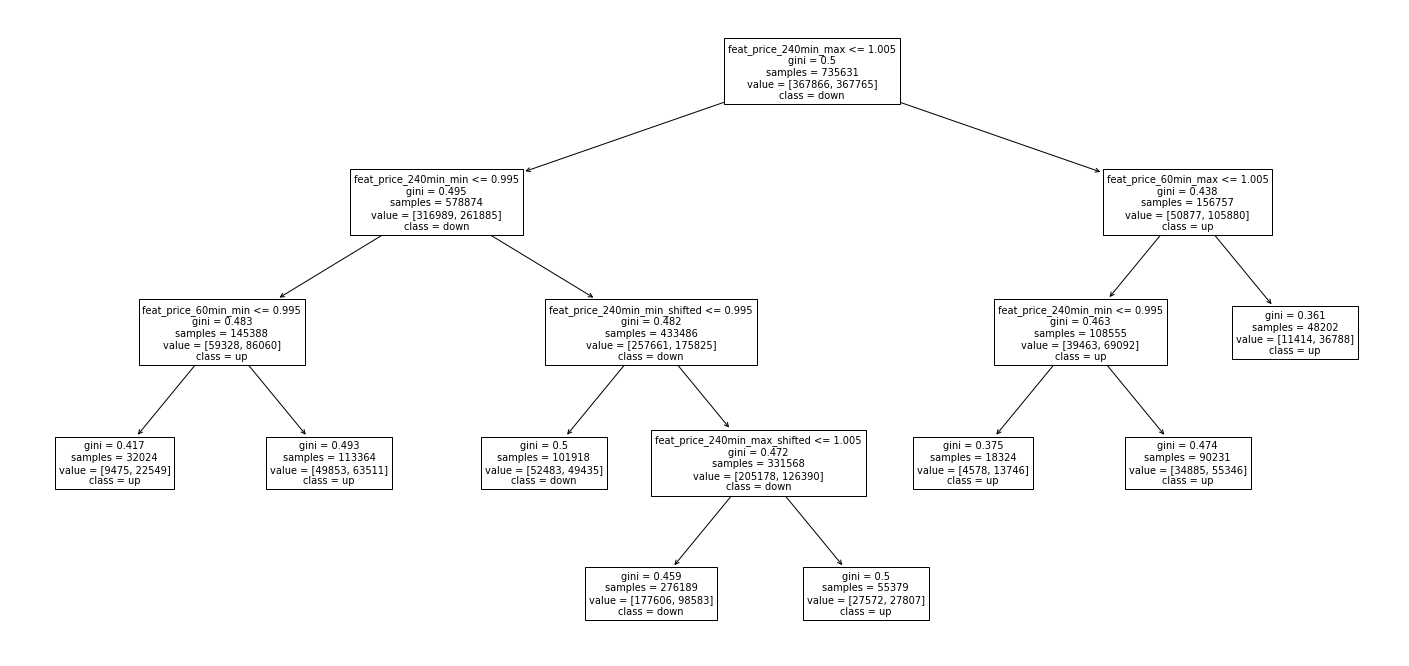

In [155]:
f, ax = plt.subplots(figsize=(25, 12))

tree.plot_tree(clf, class_names = ['down', 'up'], feature_names = features)
print()

#### BUY LOGIC

In [8]:
from datetime import time

df['fika_entry'] = df['price'].shift(45)
df['fika_entry'] = df['price'].div(df['fika_entry'])

df.loc[(df['time']!=time(10, 0)), 'fika_entry'] = np.nan
df.loc[(df['time']==time(10, 0)) & (df['fika_entry']<=1), 'fika_entry'] = np.nan
df.loc[(df['time']==time(10, 0)) & (df['fika_entry']>1), 'fika_entry'] = df['price']

#df['fika_entry'] = df['fika_entry'].shift(1)

df = df.set_index(['date','time'])
df['fika_entry'] = df['fika_entry'].unstack().ffill(axis=1).shift(1, axis=1).stack()
df = df.reset_index()

df.loc[~df['fika_entry'].isna(),'fika_price'] = df['price']
df.loc[~df['fika_entry'].isna(),'fika_buy'] = 1

df.head(70).tail(20)

,date,time,price,datetime,year,month,day,datetime_diff,hour_gap,new_day,return,return_new_day,fika_entry,fika_price,fika_buy
50,2019-08-01,09:50:00,115.386750,2019-08-01 09:50:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999127,NaN,NaN,NaN,NaN
51,2019-08-01,09:51:00,115.418750,2019-08-01 09:51:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000277,NaN,NaN,NaN,NaN
52,2019-08-01,09:52:00,115.469937,2019-08-01 09:52:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000443,NaN,NaN,NaN,NaN
53,2019-08-01,09:53:00,115.432375,2019-08-01 09:53:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999675,NaN,NaN,NaN,NaN
54,2019-08-01,09:54:00,115.393125,2019-08-01 09:54:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999660,NaN,NaN,NaN,NaN
55,2019-08-01,09:55:00,115.433188,2019-08-01 09:55:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000347,NaN,NaN,NaN,NaN
56,2019-08-01,09:56:00,115.462563,2019-08-01 09:56:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000254,NaN,NaN,NaN,NaN
57,2019-08-01,09:57:00,115.438000,2019-08-01 09:57:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999787,NaN,NaN,NaN,NaN
58,2019-08-01,09:58:00,115.468687,2019-08-01 09:58:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000266,NaN,NaN,NaN,NaN
59,2019-08-01,09:59:00,115.530000,2019-08-01 09:59:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000531,NaN,NaN,NaN,NaN


In [9]:
df = df.set_index(['date','time'])
df['fika_max'] = df['fika_price'].unstack().cummax(axis=1).stack()
df = df.reset_index()

df.head(70).tail(20)

,date,time,price,datetime,year,month,day,datetime_diff,hour_gap,new_day,return,return_new_day,fika_entry,fika_price,fika_buy,fika_max
50,2019-08-01,09:50:00,115.386750,2019-08-01 09:50:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999127,NaN,NaN,NaN,NaN,NaN
51,2019-08-01,09:51:00,115.418750,2019-08-01 09:51:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000277,NaN,NaN,NaN,NaN,NaN
52,2019-08-01,09:52:00,115.469937,2019-08-01 09:52:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000443,NaN,NaN,NaN,NaN,NaN
53,2019-08-01,09:53:00,115.432375,2019-08-01 09:53:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999675,NaN,NaN,NaN,NaN,NaN
54,2019-08-01,09:54:00,115.393125,2019-08-01 09:54:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999660,NaN,NaN,NaN,NaN,NaN
55,2019-08-01,09:55:00,115.433188,2019-08-01 09:55:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000347,NaN,NaN,NaN,NaN,NaN
56,2019-08-01,09:56:00,115.462563,2019-08-01 09:56:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000254,NaN,NaN,NaN,NaN,NaN
57,2019-08-01,09:57:00,115.438000,2019-08-01 09:57:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999787,NaN,NaN,NaN,NaN,NaN
58,2019-08-01,09:58:00,115.468687,2019-08-01 09:58:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000266,NaN,NaN,NaN,NaN,NaN
59,2019-08-01,09:59:00,115.530000,2019-08-01 09:59:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000531,NaN,NaN,NaN,NaN,NaN


In [10]:
# SELL LOGIC, 
df['fika_sell'] = np.nan
df.loc[(df['fika_price'] < df['fika_max']*0.995),'fika_sell'] = 1

df = df.set_index(['date','time'])
df['fika_sell'] = df['fika_sell'].unstack().ffill(axis=1).stack()
df = df.reset_index()

In [11]:
df['fika_hold'] = np.nan

df.loc[(df['fika_buy']==1) & (df['fika_sell'].isna()), 'fika_hold'] = 1
df['fika_hold'] = df['fika_hold']#.shift(1)
df.head(70).tail(20)

,date,time,price,datetime,year,month,day,datetime_diff,hour_gap,new_day,return,return_new_day,fika_entry,fika_price,fika_buy,fika_max,fika_sell,fika_hold
50,2019-08-01,09:50:00,115.386750,2019-08-01 09:50:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2019-08-01,09:51:00,115.418750,2019-08-01 09:51:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2019-08-01,09:52:00,115.469937,2019-08-01 09:52:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2019-08-01,09:53:00,115.432375,2019-08-01 09:53:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2019-08-01,09:54:00,115.393125,2019-08-01 09:54:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2019-08-01,09:55:00,115.433188,2019-08-01 09:55:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2019-08-01,09:56:00,115.462563,2019-08-01 09:56:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2019-08-01,09:57:00,115.438000,2019-08-01 09:57:00,2019,8,1,0 days 00:01:00,0.016667,0,0.999787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2019-08-01,09:58:00,115.468687,2019-08-01 09:58:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2019-08-01,09:59:00,115.530000,2019-08-01 09:59:00,2019,8,1,0 days 00:01:00,0.016667,0,1.000531,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.loc[df['fika_hold']==1].set_index('datetime')['return'].cumprod()

datetime
2019-08-01 10:01:00    1.000255
2019-08-01 10:02:00    1.000525
2019-08-01 10:03:00    1.000698
2019-08-01 10:04:00    1.000255
2019-08-01 10:05:00    0.999827
                         ...   
2022-07-08 11:03:00    1.398352
2022-07-08 11:04:00    1.398147
2022-07-08 11:05:00    1.397528
2022-07-08 11:06:00    1.397353
2022-07-08 11:07:00    1.396396
Name: return, Length: 76724, dtype: float64

<AxesSubplot:xlabel='datetime'>

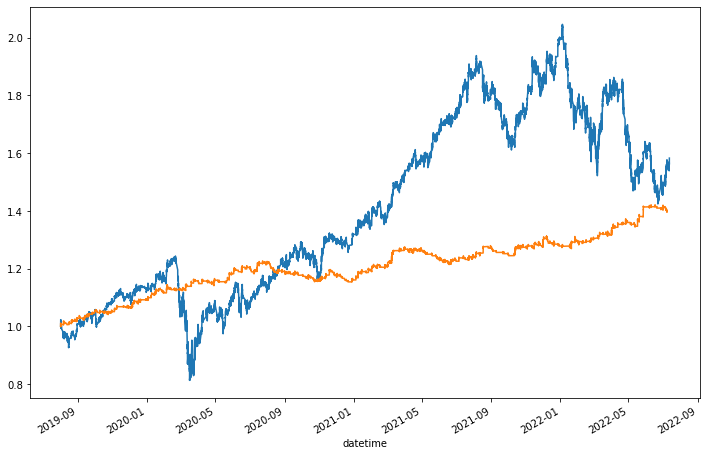

In [13]:
f, ax = plt.subplots(figsize= (12, 8))
df.set_index('datetime')['return'].cumprod().plot(ax=ax)
df.loc[df['fika_hold']==1].set_index('datetime')['return'].cumprod().plot(ax=ax)
#df[df['datetime'].isin()]

In [1011]:
dates = df[df['fika_hold']==1]['date'].unique()
df.loc[(df['date'].isin(dates))].groupby('date')['return'].prod().sort_values().tail(10)

date
2022-03-29    1.051508
2020-04-29    1.056541
2020-05-27    1.058997
2020-06-05    1.069040
2020-04-07    1.069141
2020-03-19    1.070315
2020-01-30    1.088176
2020-04-06    1.088217
2020-03-25    1.097875
2020-03-24    1.113371
Name: return, dtype: float64

237350    1.001772
Name: return, dtype: float64
220685    1.001368
Name: return, dtype: float64
249470    1.003081
Name: return, dtype: float64
284820    0.999858
Name: return, dtype: float64
57065    0.998599
Name: return, dtype: float64
337845    1.003138
Name: return, dtype: float64
208060    0.993823
Name: return, dtype: float64
355520    1.003533
Name: return, dtype: float64
308555    1.005362
Name: return, dtype: float64
69185    0.994829
Name: return, dtype: float64


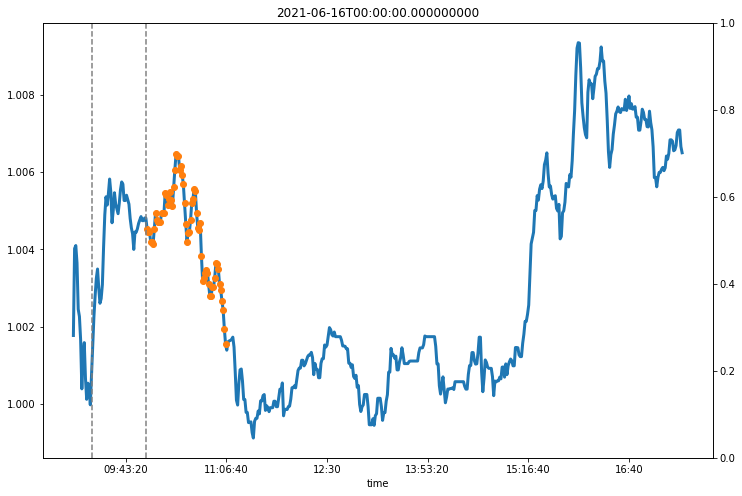

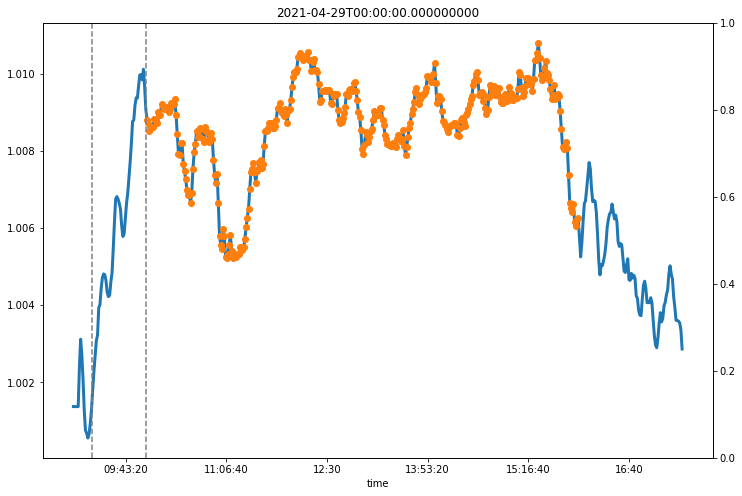

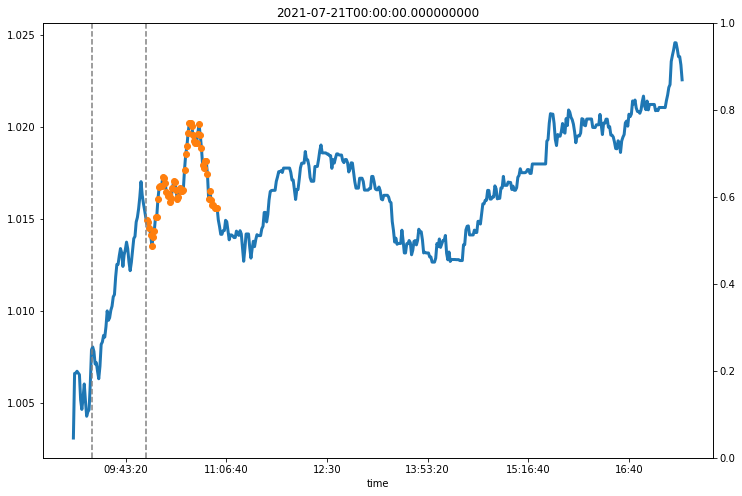

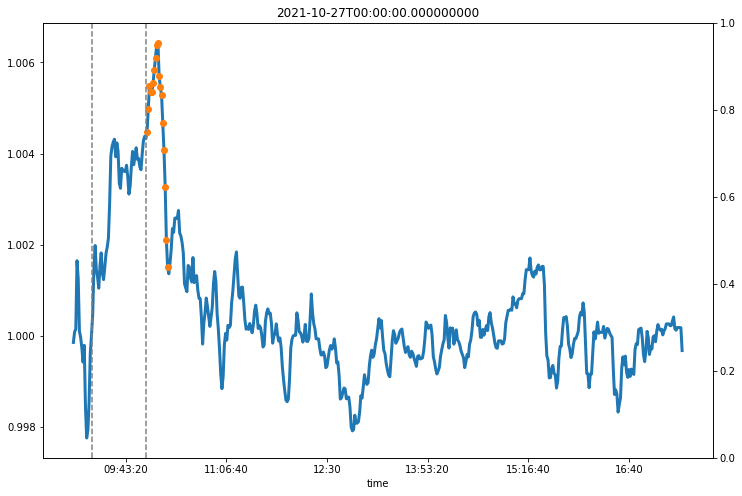

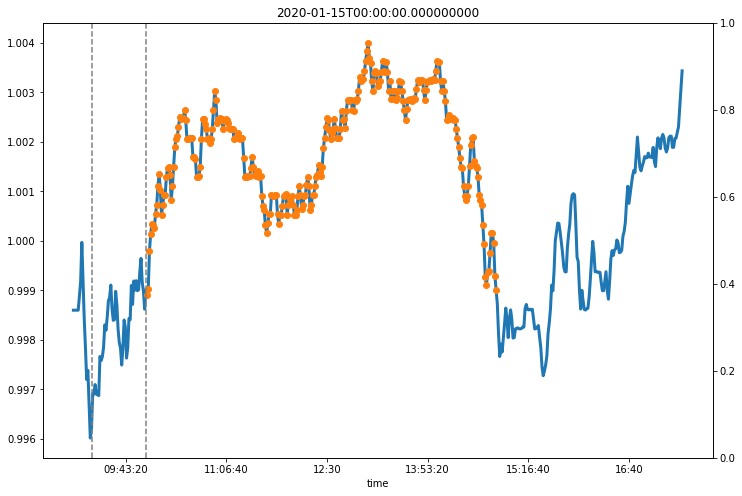

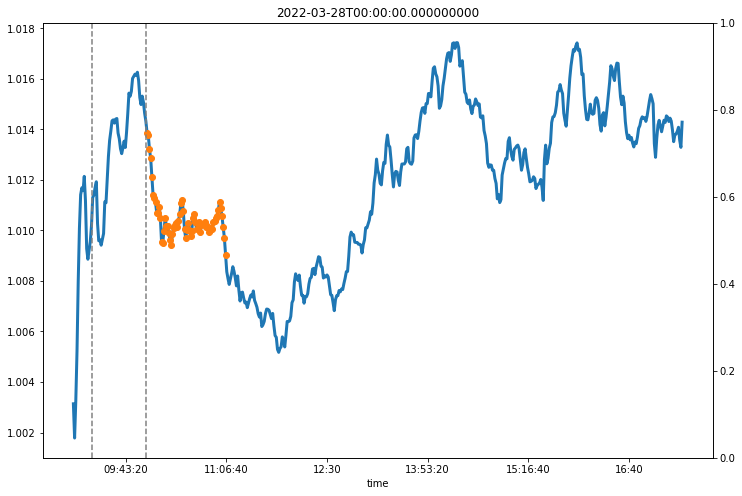

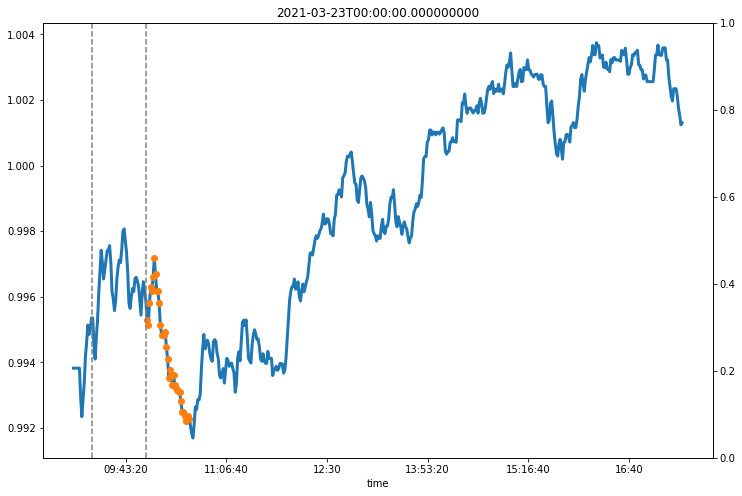

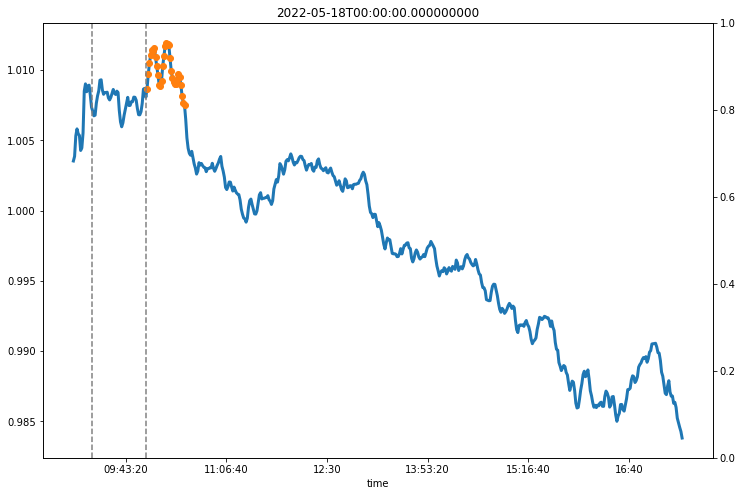

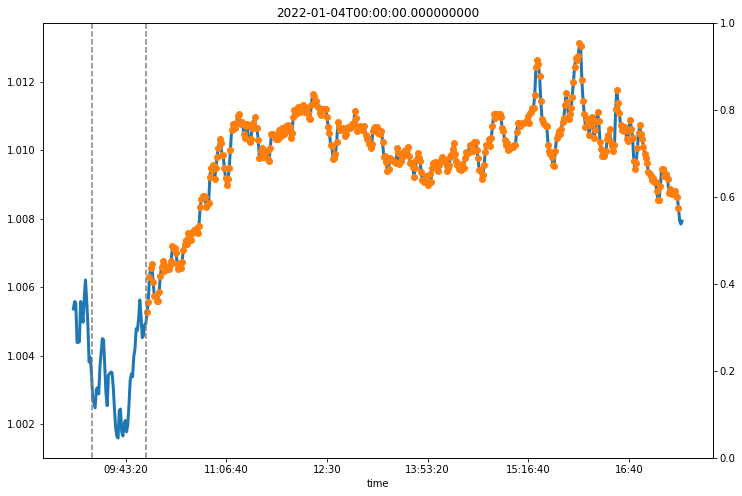

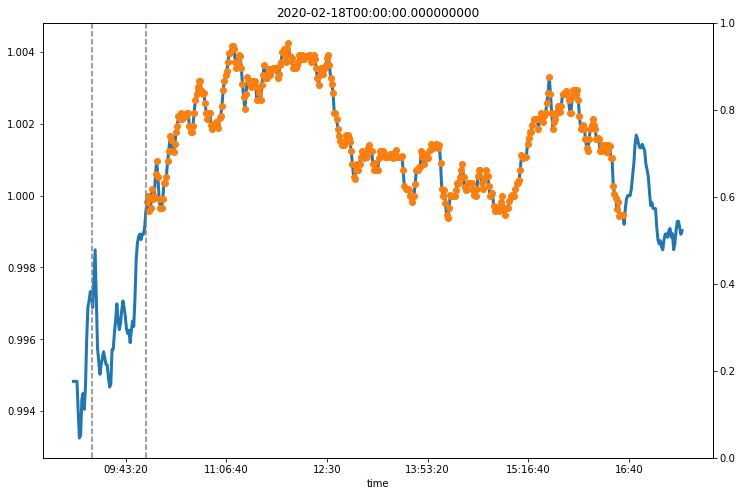

In [14]:
dates = df[df['fika_hold']==1]['date'].unique()
random_date = df.loc[(df['date'].isin(dates))].groupby('date')['return'].prod().sort_values().tail(10).index
random_date = np.random.choice(dates, 20)

for day in random_date[:10]:
    random_date = day
    print(df[(df['date']==random_date) & (df['new_day']==1)]['return'])
    #gap = df[(df['date']==random_date) & (df['new_day']==1)].iloc[0]['return']
    f, ax = plt.subplots(figsize= (12, 8))
        
    df_cum = df[(df['date']==random_date)].set_index('time')['return'].cumprod()
    df_cum.plot(title=str(random_date),ax=ax, lw=3)
    df_cum.loc[df[(df['date']==random_date) & (df['fika_hold']==1)]['time'].values].plot(ax=ax, ls='', marker='o')
    #df_cum.loc[df[df['return_10min']==1.002]['datetime'].values].plot(ax=ax, ls='', marker='o')
    ax2 = ax.twinx()

    #df[(df['date']==random_date) & (df['return_10min']==1.002)].set_index('time')['return'].cumprod().plot(ax=ax, color='r', ls='', marker='o')
    #df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).agg(lambda x : x.prod()).plot(ax=ax2, color='orange')
    #df[(df['date']==random_date)].set_index('time')['volume'].rolling(10).mean().plot(ax=ax2, color='r')
    #ax2.set(zorder=99)
    #ax2.axhline(0, color='grey', ls='--')
    ax.axvline('10:00', color='grey', ls='--')
    #ax2.axvline('11:00', color='grey', ls='--')
    ax.axvline('09:15', color='grey', ls='--')

In [990]:
df.groupby('new_day')['return'].prod()

new_day
0    1.174989
1    0.665986
Name: return, dtype: float64

In [546]:
df[(df['date']==random_date)].iloc[0]['pct_change']

1.0175487633219384

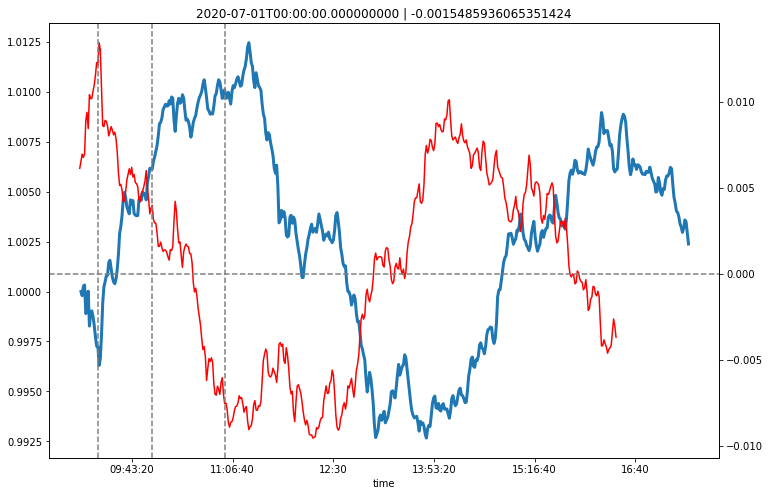

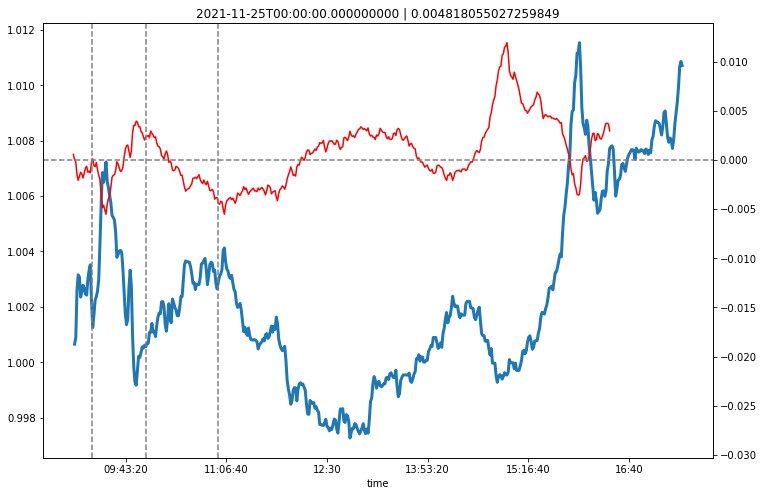

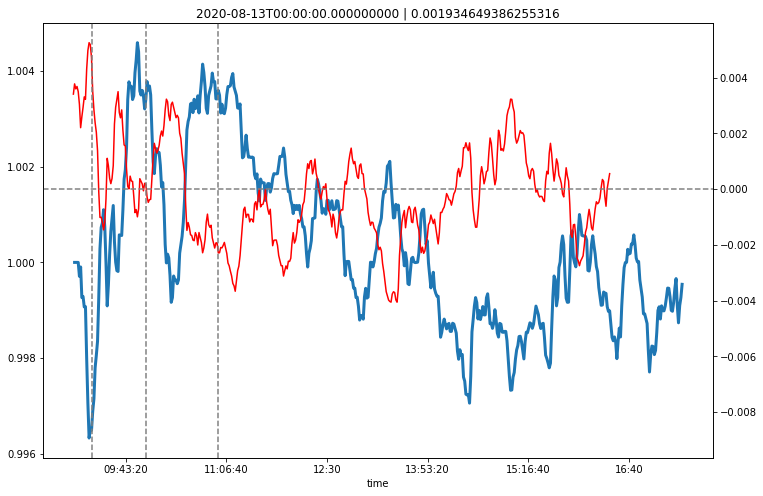

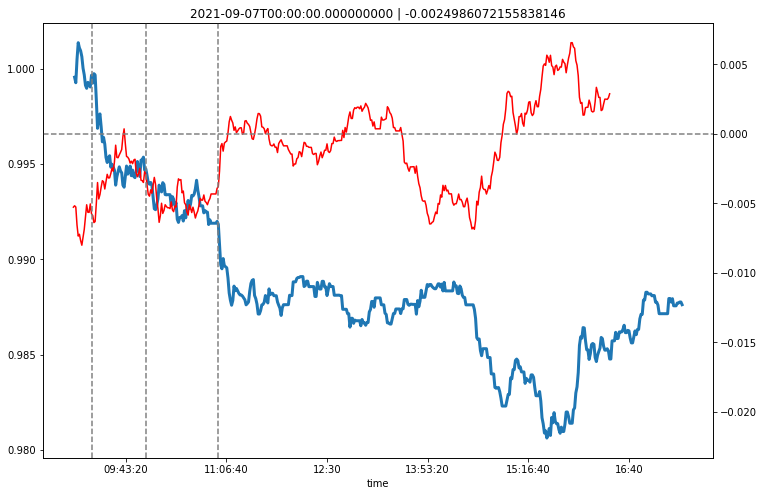

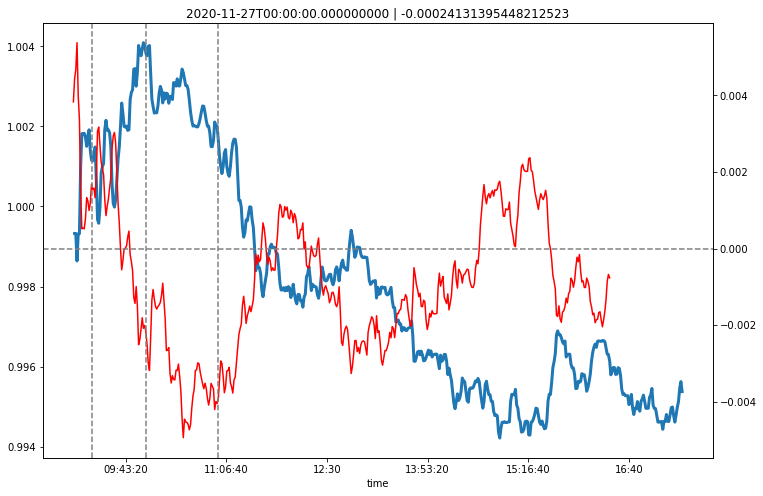

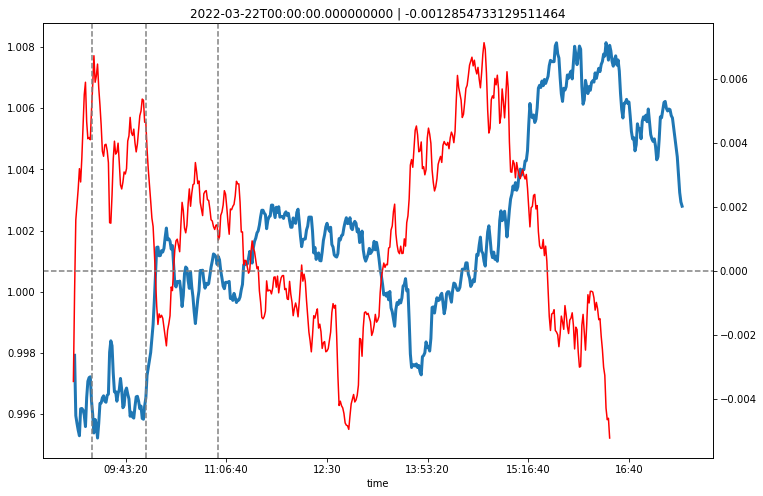

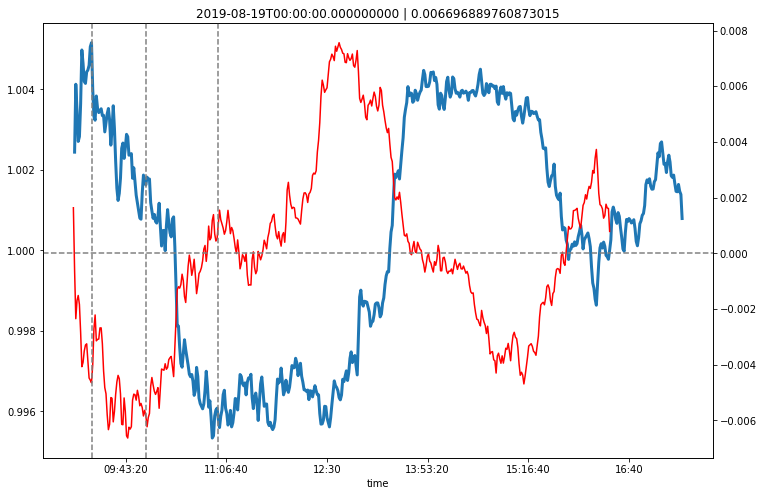

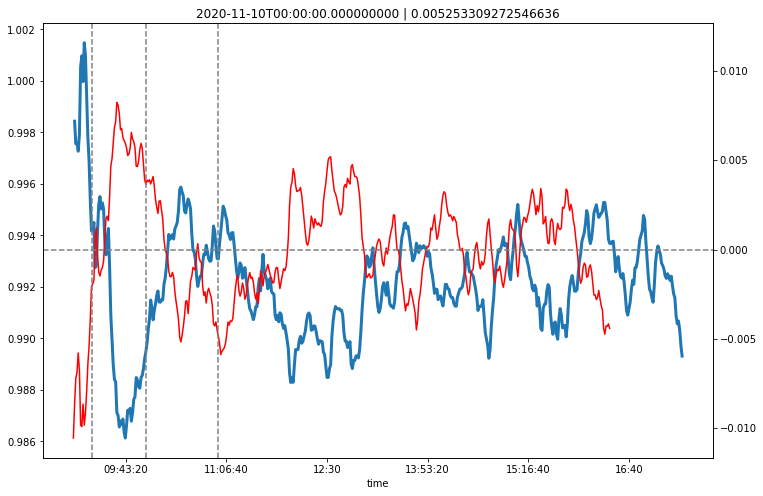

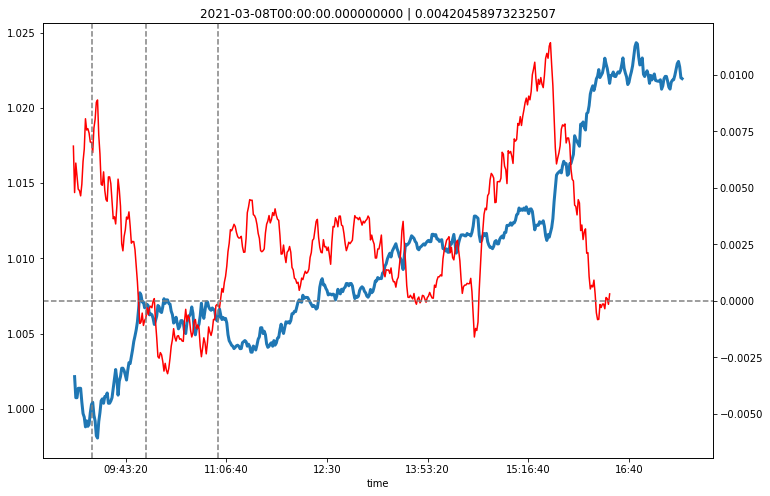

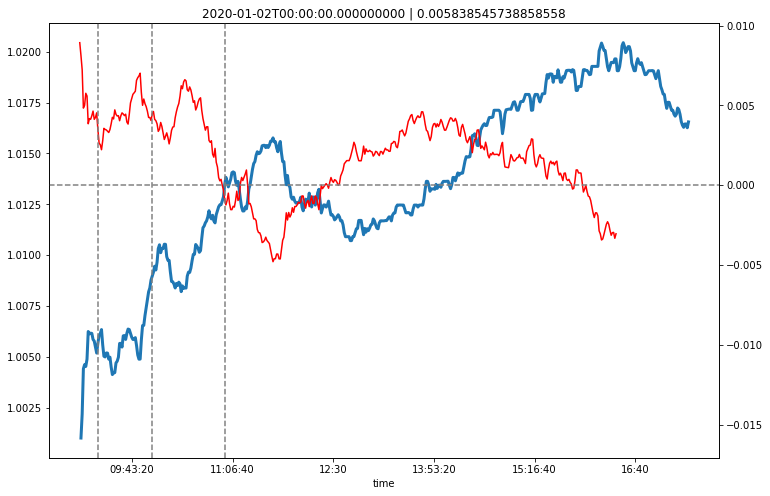

In [655]:

random_date = np.random.choice(df['date'].unique(), 10)

for day in random_date:
    random_date = day
    gap = df[(df['date']==random_date) & (df['new_day']==1)].iloc[0]['return']
    f, ax = plt.subplots(figsize= (12, 8))
    df[(df['date']==random_date) & (df['new_day']==0)].set_index('time')['return'].add(1).cumprod().plot(title=str(random_date)+' | '+str(gap),ax=ax, lw=3)
    ax2 = ax.twinx()

    df[df['date']==random_date].set_index('time')['return_60min'].plot(ax=ax2, color='r')
    #df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).agg(lambda x : x.prod()).plot(ax=ax2, color='orange')
    #df[(df['date']==random_date)].set_index('time')['volume'].rolling(10).mean().plot(ax=ax2, color='r')
    #ax2.set(zorder=99)
    ax2.axhline(0, color='grey', ls='--')
    ax2.axvline('10:00', color='grey', ls='--')
    ax2.axvline('11:00', color='grey', ls='--')
    ax2.axvline('09:15', color='grey', ls='--')

In [463]:
df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).mean()

time
09:00:00         NaN
09:01:00         NaN
09:02:00         NaN
09:03:00         NaN
09:04:00         NaN
              ...   
17:20:00    1.000006
17:21:00    1.000038
17:22:00    1.000085
17:23:00    1.000026
17:24:00    1.000111
Name: pct_change, Length: 494, dtype: float64

In [401]:
df[df['date']==random_date].set_index('time')['pct_change']

time
09:00:00    0.980845
09:01:00    0.977801
09:02:00    0.979036
09:03:00    0.976894
09:04:00    0.975302
              ...   
17:20:00    0.962905
17:21:00    0.962844
17:22:00    0.963046
17:23:00    0.962451
17:24:00    0.961413
Name: pct_change, Length: 505, dtype: float64

In [314]:
df_cell = df[df['year']==2022].set_index(['month', 'day','time'])['close'].unstack(level=[0,1]).bfill().ffill()
df_cell = df_cell.div(df_cell.iloc[0], axis=1)
df_cell

month            1                                                    \
day             3         4         5         7         10        11   
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.999671  1.000267  0.999557  1.002585  0.999518  0.998492   
09:02:00  0.999974  0.999285  0.999488  0.999026  0.998815  1.001840   
09:03:00  0.999846  0.998289  0.998203  1.001624  1.000212  1.000273   
09:04:00  1.000000  0.998690  0.998027  1.002140  1.000942  0.999800   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.012516  1.002879  0.983304  1.000432  0.968365  0.992339   
17:21:00  1.012560  1.002448  0.983304  1.001206  0.968387  0.993013   
17:22:00  1.012748  1.002138  0.983304  1.002238  0.967476  0.993642   
17:23:00  1.012481  1.002086  0.983304  1.002474  0.968166  0.993642   
17:24:00  1.012261  1.002392  0.983304  1.002278  0.968100  0.994562   

month                                             ...         6            \
day             12        13        14        17  ...        29        30   
time                                              ...                       
09:00:00  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
09:01:00  0.996421  0.998925  0.998289  0.998870  ...  0.998374  1.000988   
09:02:00  0.998256  0.998999  0.999780  1.001283  ...  1.000855  0.999286   
09:03:00  0.998010  1.000155  0.996391  1.000505  ...  1.000095  0.997910   
09:04:00  0.998065  0.999817  0.993386  0.998169  ...  0.999852  0.999429   
...            ...       ...       ...       ...  ...       ...       ...   
17:20:00  0.995072  0.990956  0.974964  1.003395  ...  1.009396  1.001292   
17:21:00  0.995103  0.991413  0.974993  1.002265  ...  1.009075  1.000637   
17:22:00  0.995158  0.992300  0.975128  1.002341  ...  1.008363  1.000702   
17:23:00  0.994917  0.990928  0.975563  1.002403  ...  1.007936  1.000976   
17:24:00  0.994649  0.991742  0.976222  1.003819  ...  1.007823  1.000405   

month            7                                                    \
day             1         4         5         6         7         8    
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.995581  0.998380  0.999589  1.003179  1.000056  1.000578   
09:02:00  0.994767  1.002926  1.001545  1.003755  1.001429  0.999080   
09:03:00  0.995563  1.000664  1.001719  1.005735  0.999006  1.001380   
09:04:00  0.994755  1.001096  1.001314  1.005158  1.001525  1.000370   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.018496  0.997313  0.986685  1.021466  1.006643  1.007665   
17:21:00  1.017412  0.997098  0.986165  1.020913  1.006880  1.008102   
17:22:00  1.017598  0.996917  0.985737  1.021087  1.006134  1.008214   
17:23:00  1.017969  0.996847  0.984828  1.021367  1.006383  1.008248   
17:24:00  1.016047  0.996783  0.983723  1.021110  1.005264  1.008658   

month                         
day             11        12  
time                          
09:00:00  1.000000  1.000000  
09:01:00  1.000000  1.000476  
09:02:00  1.000000  1.002611  
09:03:00  1.000000  1.003184  
09:04:00  1.000000  1.003019  
...            ...       ...  
17:20:00  1.001443  1.022630  
17:21:00  1.001556  1.022721  
17:22:00  1.001556  1.023146  
17:23:00  1.001809  1.023553  
17:24:00  1.001780  1.024522  

[505 rows x 131 columns]

<AxesSubplot:xlabel='time'>

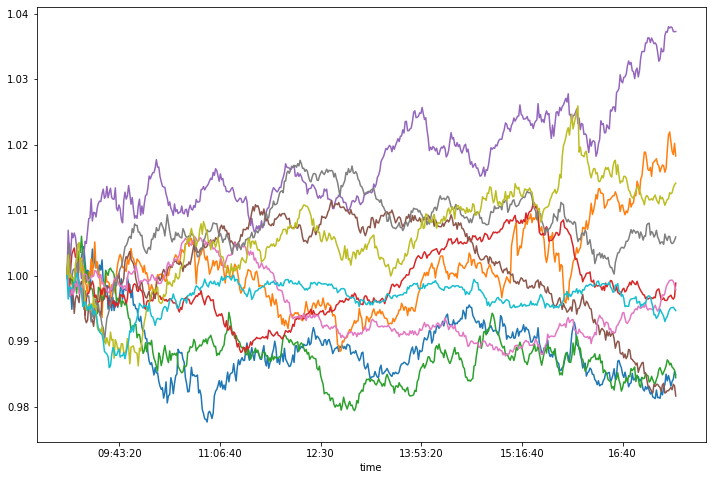

In [304]:
f, ax = plt.subplots(figsize= (12, 8))
df_cell.sample(1, axis=1).plot(ax=ax, legend=False)

<AxesSubplot:xlabel='datetime'>

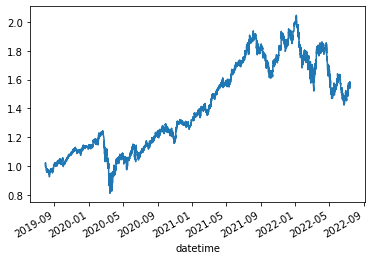

In [246]:
df.groupby(['datetime'])['pct_change'].prod().cumprod().plot()

<AxesSubplot:xlabel='date'>

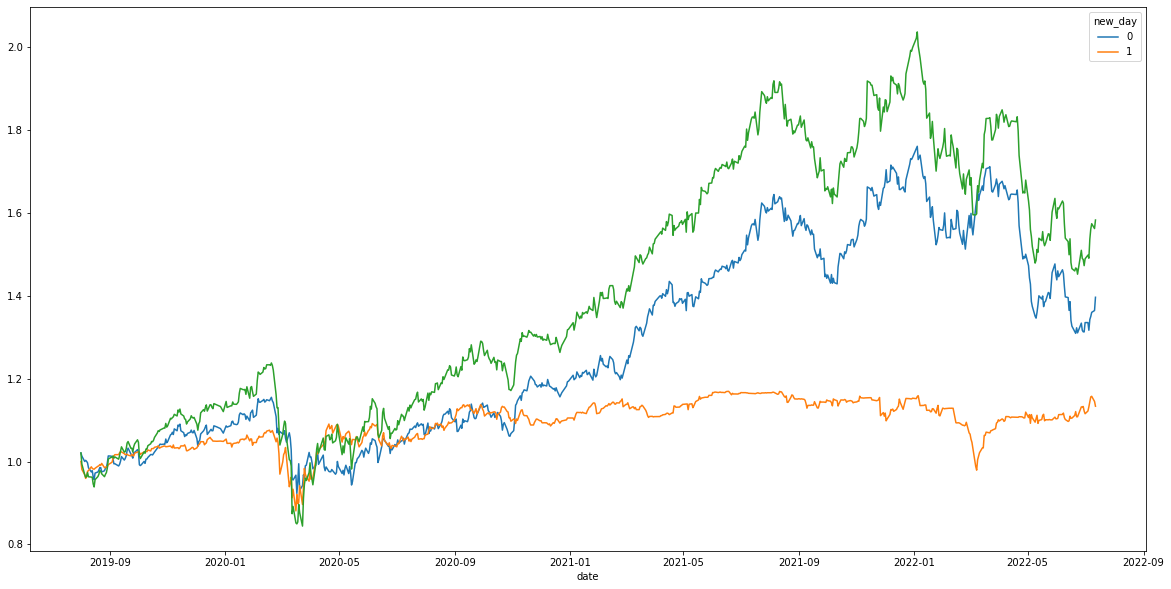

In [243]:
f, ax = plt.subplots(figsize= (20, 10))

df.groupby(['date', 'new_day'])['pct_change'].prod().unstack().fillna(1).cumprod().plot(ax=ax)
df.groupby(['date'])['pct_change'].prod().cumprod().plot(ax=ax)

In [183]:
df['pct_change'].prod()

1.5830616326546936

In [186]:
df.groupby('new_day')['pct_change'].prod()

1.5830616326548537

month            1         5                                          \
day             3         18        17        16        13        12   
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.999671  1.001499  0.998749  0.998450  0.996873  1.000915   
09:02:00  0.999974  1.003049  1.000967  1.000511  0.994527  0.999504   
09:03:00  0.999846  1.002032  1.001313  1.001045  0.994001  0.999428   
09:04:00  1.000000  1.003105  1.003576  1.001856  0.994117  1.001334   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.012516  0.981967  1.008858  0.993982  1.013113  1.016063   
17:21:00  1.012560  0.981742  1.008836  0.993869  1.013627  1.014795   
17:22:00  1.012748  0.981473  1.008983  0.994175  1.014165  1.014694   
17:23:00  1.012481  0.980945  1.009308  0.993687  1.015297  1.013880   
17:24:00  1.012261  0.980597  1.009609  0.994028  1.014777  1.012788   

month                                             ...         2            \
day             11        10        9         6   ...        28        25   
time                                              ...                       
09:00:00  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
09:01:00  0.996484  0.999106  1.002545  0.998967  ...  1.006926  1.002174   
09:02:00  0.994806  0.996731  1.001442  0.997996  ...  1.003471  1.004300   
09:03:00  0.993427  0.998060  0.998891  0.996312  ...  1.003050  1.005621   
09:04:00  0.996625  0.994220  0.999994  0.998219  ...  1.006505  1.007200   
...            ...       ...       ...       ...  ...       ...       ...   
17:20:00  1.011163  0.997542  0.986615  0.988678  ...  1.037972  1.008936   
17:21:00  1.012214  0.997101  0.986019  0.989951  ...  1.037866  1.009363   
17:22:00  1.012671  0.997378  0.985839  0.990002  ...  1.037269  1.009594   
17:23:00  1.013047  0.997242  0.985564  0.990379  ...  1.037247  1.010115   
17:24:00  1.013716  0.997242  0.984408  0.989802  ...  1.037274  1.011036   

month                                                    4         7   2   7  
day             24        23        22        18        4         12  21  11  
time                                                                          
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  
09:01:00       NaN  1.001132  1.003841  1.000905  0.996021  1.000476 NaN NaN  
09:02:00       NaN  1.003520  1.005772  1.000453  0.994790  1.002611 NaN NaN  
09:03:00  0.948015  1.004066  1.009193  0.998225  0.995831  1.003184 NaN NaN  
09:04:00  0.950433  1.007123  1.011392  0.999507  0.997362  1.003019 NaN NaN  
...            ...       ...       ...       ...       ...       ...  ..  ..  
17:20:00  0.990462  0.979090  1.055371  0.984814  1.003822  1.022630 NaN NaN  
17:21:00  0.989542  0.977984  1.055420  0.984229  1.003803  1.022721 NaN NaN  
17:22:00  0.987802  0.977716  1.054874  0.984209  1.003774  1.023146 NaN NaN  
17:23:00  0.987318  0.977469  1.055147  0.984142  1.003346  1.023553 NaN NaN  
17:24:00  0.986024  0.978905  1.053805  0.984458  1.003627  1.024522 NaN NaN  

[505 rows x 131 columns]

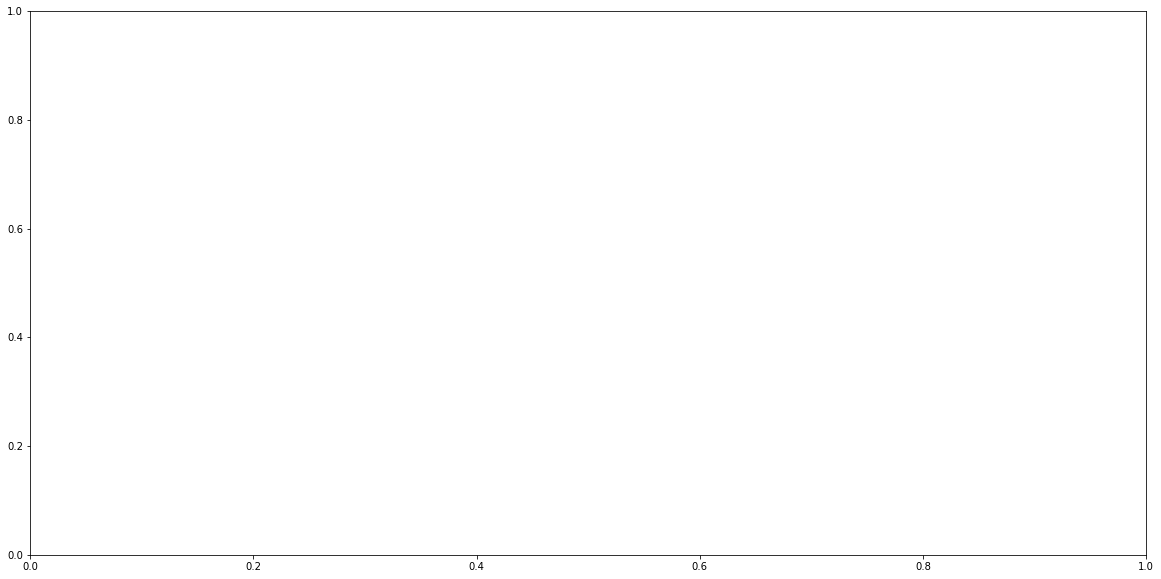

In [129]:
f, ax = plt.subplots(figsize= (20, 10))
df_cell = df[df['year']==2022].groupby(['month', 'day', 'time'])['close'].mean().unstack(level=[0,1])
df_cell.div(df_cell.iloc[0, :], axis=1).sort_values(by=df_cell.index[0], axis=1)#.plot(ax=ax, legend=False)